# Лабораторная работа 5
Градиентный бустинг с Catboost

Выполнила: Кривоконева Екатерина, группа 6133

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

import warnings
import sys  
warnings.simplefilter("ignore")

In [ ]:
! pip install catboost shap ipywidgets
! jupyter nbextension enable --py widgetsnbextension

## 0 Подобрать набор данных для классификации

Датасет: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset


Числовые признаки:

- id - Unique id
- age - Age
- hypertension - Hypertension binary feature
- heart_disease - Heart disease binary feature
- avg_glucose_level - Average glucose level in blood
- bmi - Body Mass Index
- stroke - Stroke event

Категориальные признаки:

- gender - Gender
- work_type - Work type of the patient
- Residence_type - Residence type of the patient
- smoking_status - Smoking status of the patient

Бинарные признаки:

- ever_married - Has the patient ever been married? (true/false)


In [2]:
data = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
data.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [4]:
# A really fantsatic and intelligent way to deal with blanks, from Thoman Konstantin in: https://www.kaggle.com/thomaskonstantin/analyzing-and-modeling-stroke-data

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

DT_bmi_pipe = Pipeline( steps=[
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=42))
                              ])
X = data[['age', 'gender', 'bmi']].copy()
X.gender = X.gender.replace({'Male':0, 'Female':1, 'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age', 'gender']]),index=Missing.index)
data.loc[Missing.index,'bmi'] = predicted_bmi

In [5]:
print('Missing values: ', sum(data.isnull().sum()))

Missing values:  0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Распределение целеовй переменной:

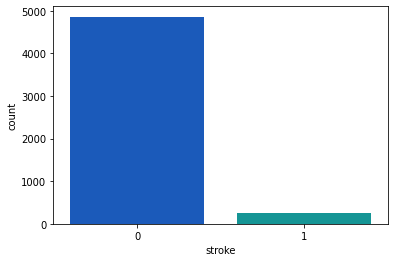

In [7]:
import seaborn as sns 

sns.countplot(data.stroke, palette='winter')
plt.show()

Так как данные сильно несбаланисрованы, создадим новый train датасет методом upsampling:

In [8]:
train_data = data.sample(frac=0.6, random_state=25)

In [9]:
rat = len(train_data.loc[train_data['stroke']==0])//len(train_data.loc[train_data['stroke']==1])

In [10]:
df_1 = train_data.loc[train_data['stroke']==1]
df_1 = df_1.loc[df_1.index.repeat(rat)]
train_n = pd.concat([train_data.loc[train_data['stroke']==0], df_1]).sample(frac=1)

In [11]:
test_data = data.drop(labels=train_data.index)
X_train = train_n[train_n.columns.difference(['stroke'])]
y_train = train_n['stroke']
X_test = test_data[test_data.columns.difference(['stroke'])]
y_test = test_data['stroke']

## 1 Применить классификатор CatBoostClassifier к набору данных 

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5658 entries, 887 to 236
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Residence_type     5658 non-null   object 
 1   age                5658 non-null   float64
 2   avg_glucose_level  5658 non-null   float64
 3   bmi                5658 non-null   float64
 4   ever_married       5658 non-null   object 
 5   gender             5658 non-null   object 
 6   heart_disease      5658 non-null   int64  
 7   hypertension       5658 non-null   int64  
 8   id                 5658 non-null   int64  
 9   smoking_status     5658 non-null   object 
 10  work_type          5658 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 530.4+ KB


In [13]:
# колонки категориальных признаков
cat_features = list([0, 4, 5, 9, 10]) 

In [16]:
from catboost import CatBoostClassifier
from catboost import Pool

In [17]:
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    loss_function='Logloss', 
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    verbose = False
)

print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 100, 'learning_rate': 0.1, 'loss_function': 'Logloss'}


### Вывести итерацию с наилучшим значением AUC (для бинарной классификации) или наилучшим значением Logloss

In [18]:
model.get_best_iteration()

99

In [19]:
model.best_score_

{'learn': {'Logloss': 0.276393778539484},
 'validation': {'Logloss': 0.3366458127131588}}

### Вывести значения метрик качества классификации на тестовых данных (accuracy и precision / recall / AUC, если применимо)

In [20]:
print(classification_report(model.predict(X_test), y_test, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90      1652
           1       0.67      0.15      0.24       392

    accuracy                           0.82      2044
   macro avg       0.75      0.57      0.57      2044
weighted avg       0.80      0.82      0.77      2044



### Построить кривые PRC и ROC. Вычислить значения PRC-AUC и ROC-AUC

In [21]:
from catboost.utils import get_roc_curve
import sklearn.metrics

In [22]:
eval_pool = Pool(X_test, y_test, cat_features=cat_features) 
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

print('ROC-AUC: ' + str(roc_auc)) 

ROC-AUC: 0.8381113480050981


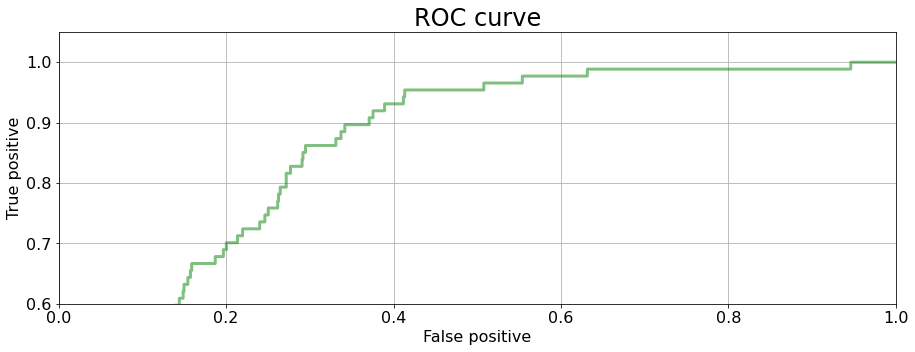

In [23]:
plt.figure(figsize=(15, 5))

plt.plot(fpr, tpr, color='green', lw=3, label='ROC curve (area = %0.3f)' % roc_auc, alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.6, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False positive', fontsize=16)
plt.ylabel('True positive', fontsize=16)
plt.title('ROC curve', fontsize=24)
plt.show()

In [24]:
s = sklearn.metrics.average_precision_score(pd.factorize(y_test)[0], model.predict_proba(X_test)[:,0]) 
print('RPC-AUC: ' + str(s))

RPC-AUC: 0.9907358343860895


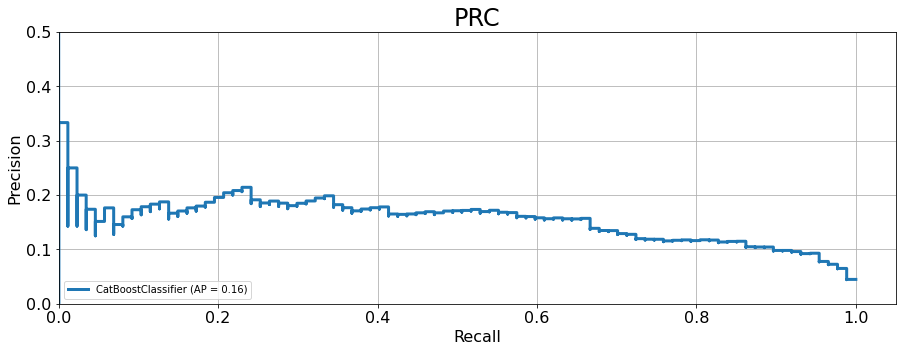

In [38]:
fig, ax = plt.subplots(figsize=(15, 5))


sklearn.metrics.plot_precision_recall_curve(model, X_test, y_test, ax=ax, lw = 3)

plt.xlim([0.0, 1.05])
plt.ylim([0.0, 0.50])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('PRC', fontsize=24)

plt.show()

## 2 Применить регрессию CatBoostRegressor к набору данных для регрессии

In [26]:
mach = data 
col = list(['gender','ever_married','work_type', 'Residence_type', 'smoking_status'])

In [27]:
# факторизуем категориальные признаки
for num in col: 
    mach[num] = pd.factorize(data[num])[0]

In [28]:
mach.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,1,0,0,0,228.69,36.600000,0,1
1,51676,1,61.0,0,0,0,1,1,202.21,29.879487,1,1
2,31112,0,80.0,0,1,0,0,1,105.92,32.500000,1,1
3,60182,1,49.0,0,0,0,0,0,171.23,34.400000,2,1
4,1665,1,79.0,1,0,0,1,1,174.12,24.000000,1,1


In [29]:
train_data = mach.sample(frac=0.6, random_state=25)
rat = len(train_data.loc[train_data['stroke']==0])//len(train_data.loc[train_data['stroke']==1])
df_1 = train_data.loc[train_data['stroke']==1]
df_1 = df_1.loc[df_1.index.repeat(rat)]
train_n = pd.concat([train_data.loc[train_data['stroke']==0], df_1]).sample(frac=1)

In [30]:
test_data = mach.drop(labels=train_data.index)
X_train_r = train_n[train_n.columns.difference(['stroke'])]
y_train_r = train_n['stroke']
X_test_r = test_data[test_data.columns.difference(['stroke'])]
y_test_r = test_data['stroke']

In [31]:
from catboost import CatBoostRegressor

In [32]:
model_r = CatBoostRegressor(iterations=500, learning_rate=0.1, use_best_model=True, loss_function = 'RMSE') 
model_r.fit(X_train_r, y_train_r, verbose=False, eval_set=(X_test_r, y_test_r))

### Вывести номер итерации и значения метрик (MAE и MSE) для наилучшей итерации

In [33]:
model_r.get_best_iteration()

499

In [34]:
print('MAE: ' + str(sklearn.metrics.mean_absolute_error(y_test_r, model_r.predict(data=X_test_r))))#считаем метрики
print('MSE: ' + str(sklearn.metrics.mean_squared_error(y_test_r, model_r.predict(data=X_test_r))))


MAE: 0.16043299030663544
MSE: 0.0641316844642793


In [35]:
model_r = CatBoostRegressor(iterations=500, learning_rate=0.1, use_best_model=True, loss_function = 'MAE') 
model_r.fit(X_train_r, y_train_r, verbose=False, eval_set=(X_test_r, y_test_r))


In [36]:
model_r.get_best_iteration() 

0

In [37]:
print('MAE: ' + str(sklearn.metrics.mean_absolute_error(y_test_r, model_r.predict(data=X_test_r))))
print('MSE: ' + str(sklearn.metrics.mean_squared_error(y_test_r, model_r.predict(data=X_test_r))))


MAE: 0.07191807295390781
MSE: 0.038542084163603225
